In [28]:
!pip install nltk
!pip install sumy
!pip install pytrends
!pip install tqdm
!pip install ratelimit
!pip install bs4
!pip install requests
!pip install pandas
!pip install textstat
!pip install Pillow
!pip install matplotlib
!pip install profanity-filter


UnboundLocalError: local variable 'child' referenced before assignment

In [ ]:


import json
import textwrap
# import pytrends
# from pytrends.request import TrendReq
import nltk
from nltk.corpus import wordnet
import random
from tqdm import tqdm
from nltk.corpus import wordnet
from nltk.metrics.distance import edit_distance
from nltk.corpus import stopwords
# PlaintextParser
from sumy.parsers.plaintext import PlaintextParser
# LexRankSummarizer
from sumy.summarizers.lex_rank import LexRankSummarizer
# LsaSummarizer
from sumy.summarizers.lsa import LsaSummarizer
# define Tokenizer
from sumy.nlp.tokenizers import Tokenizer
# define Stemmer
from sumy.nlp.stemmers import Stemmer
# define language
# pytrend = TrendReq(hl='en-US', tz=360)
stopwords = nltk.corpus.stopwords.words('english')


import os
from PIL import Image, ImageDraw, ImageFont
# with open("ppn_deck_cleaned.json", "w") as write_file:
#     json.dump(card_deck, write_file, indent=4)

# read card_deck from ppn_deck.json file
# with open("ppn_deck.json", "r") as read_file:
    # card_deck = json.load(read_file)
with open('ppn_deck.json', 'r') as read_file:
    card_deck = json.load(read_file)

In [ ]:
import textstat

def determine_grade_level(summary):
    """
    determine_grade_level - generates a grade level for the given summary using the Flesch-Kincaid Grade Level formula

    The Flesch-Kincaid Grade Level formula is a readability test designed to indicate how difficult a passage in English is to understand. The score is based on the average number of syllables per 100 words and the average number of words per sentence. The higher the score, the more difficult the text is to understand.

    :param summary: _description_
    :type summary: _type_
    :return: _description_
    :rtype: float
    """
    grade_level = textstat.flesch_kincaid_grade(summary)
    return grade_level

In [ ]:
# for each of the cards, generate a grade_level score and add it to the json file under the key "grade_level"
for card in tqdm(card_deck):
    summary = card['summary']
    grade_level = determine_grade_level(summary)
    card['grade_level'] = grade_level

100%|██████████| 9832/9832 [00:06<00:00, 1628.38it/s]


In [ ]:
# convert the card_deck to a json file, to a df using pandas and then to a csv file
with open("ppn_deck_cleaned.json", "w") as write_file:
    json.dump(card_deck, write_file, indent=4)

# read card_deck from ppn_deck.json file
# with open("ppn_deck.json", "r") as read_file:
# card_deck = json.load(read_file)
with open("ppn_deck_cleaned.json", "r") as read_file:
    card_deck = json.load(read_file)
    
# convert card_deck to a pandas dataframe
import pandas as pd
df = pd.DataFrame(card_deck)
df.head()

,title,summary,related,summary_short,summary_clean,point_value,grade_level
0,Climate change and cities,Climate change and cities are deeply connected...,401,Climate change and cities are deeply connected...,Moreover because of processes that create clim...,401,15.3
1,Rosetta Cammeniti,"Rosetta Cammeniti, Rosetta Rosie Cammeniti is ...",321,"Rosetta Cammeniti, Rosetta Rosie Cammeniti is ...",NaN,321,9.8
2,Spy Muppets: License to Croak,"Spy Muppets: License to Croak, Spy Muppets: Li...",164,"Spy Muppets: License to Croak, Spy Muppets: Li...",NaN,164,10.6
3,Fame in the 20th Century,"Fame in the 20th Century, Fame in the 20th Cen...",591,"Fame in the 20th Century, Fame in the 20th Cen...",NaN,591,10.6
4,Becca Hayton,"Becca Hayton, Becca Dean also Hayton is a fict...",271,"Becca Hayton, Becca Dean also Hayton is a fict...",NaN,271,10.1


<AxesSubplot: >

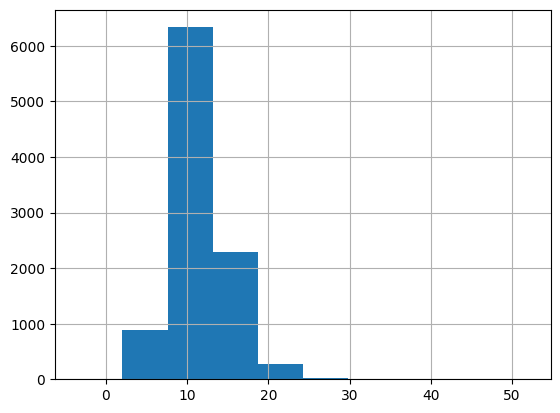

In [ ]:
# show the distribution of grade levels
df['grade_level'].hist()

In [ ]:
# points for the card should be calculated by the following formula:
# - the higher the grade level of the card, the higher the points.
# - the more words in the summary, the lower the points.
# - cards with longer titles should have higher points.
# - cards with Acronyms should have higher points.

# create a new column in the dataframe called "points_for_card"
df['points_for_card'] = 0
df['acronym'] = False # this will need to be updated later to determine if the card has an acronym or not

def determine_points(card):
    # determine the points for the card based on the following formula:
    # - the higher the grade level of the card, the higher the points.
    # - the more words in the summary, the lower the points.
    # - cards with longer titles should have higher points.
    # - cards with Acronyms should have higher points.
    grade_level = card['grade_level']
    summary = card['summary']
    title = card['title']
    acronym = card['acronym']
    related_pages = card['related']
    points = 0
    # - the higher the grade level of the card, the higher the points.
    # all _score variables will be between 0 and 100
    grade_score = grade_level
    # - the more words in the summary, the lower the points.
    summary_score = len(summary.split())
    # - cards with longer titles should have higher points.
    title_score = len(title.split())
    # - cards with Acronyms should have higher points.
    acronym_score = 0
    if acronym:
        acronym_score = 1
    # - cards with related pages should have higher points.
    try:
        related_pages_score = int(related_pages)
    except ValueError:
        related_pages_score = 0
    except Exception:
        related_pages_score = 0
    #print(grade_score)
    #print(summary_score)
    #print(title_score)
    #print(acronym_score)

    #print(related_pages_score)

    # calculate the points
    points = grade_score + summary_score + title_score + acronym_score + related_pages_score
    #print(points)

    return int(points)

# apply the determine_points function to each of the cards in the dataframe
df['points_for_card'] = df.apply(determine_points, axis=1)
# now scale the points_for_card column to be between 1 and 10, and round to the nearest integer
df['points_for_card'] = df['points_for_card'].apply(lambda x: round((x - df['points_for_card'].min()) / (df['points_for_card'].max() - df['points_for_card'].min()) * 10))
# replace any points_for_card values that are 0 with 1
df['points_for_card'] = df['points_for_card'].apply(lambda x: 1 if x == 0 else x)
# no card with a grade level above 10 should have a points_for_card value less than 5
df['points_for_card'] = df.apply(lambda x: 5 if x['grade_level'] > 10 and x['points_for_card'] < 5 else x['points_for_card'], axis=1)
df.head()

,title,summary,related,summary_short,summary_clean,point_value,grade_level,points_for_card,acronym
0,Climate change and cities,Climate change and cities are deeply connected...,401,Climate change and cities are deeply connected...,Moreover because of processes that create clim...,401,15.3,5,False
1,Rosetta Cammeniti,"Rosetta Cammeniti, Rosetta Rosie Cammeniti is ...",321,"Rosetta Cammeniti, Rosetta Rosie Cammeniti is ...",NaN,321,9.8,1,False
2,Spy Muppets: License to Croak,"Spy Muppets: License to Croak, Spy Muppets: Li...",164,"Spy Muppets: License to Croak, Spy Muppets: Li...",NaN,164,10.6,5,False
3,Fame in the 20th Century,"Fame in the 20th Century, Fame in the 20th Cen...",591,"Fame in the 20th Century, Fame in the 20th Cen...",NaN,591,10.6,5,False
4,Becca Hayton,"Becca Hayton, Becca Dean also Hayton is a fict...",271,"Becca Hayton, Becca Dean also Hayton is a fict...",NaN,271,10.1,5,False


In [ ]:
# look for years in the summary and title. Older cards should have higher points, so we will add 1 point for each year found in the summary and title (this will be scaled later)
import re
df['years_in_summary'] = df['summary'].apply(lambda x: len(re.findall(r'\d{4}', x)))
df['years_in_title'] = df['title'].apply(lambda x: len(re.findall(r'\d{4}', x)))
def points_by_year_mentioned(this_card,years_in_deck):
    # assign higher points for years that are older (i.e 1980 has higher points than 2010 etc.) This is on a scale so highest points are for the oldest years.
    # this card may mention multiple years, so we will add the points for each year mentioned by where it falls in the scale of years in the deck.
    # for example, if the card mentions 1980 and 2010, and the deck has cards from 1980 to 2020, then the points for the card will be 1 + 10 = 11
    points = 0
    years_in_summary = this_card['years_in_summary']
    years_in_title = this_card['years_in_title']
    years_mentioned = years_in_summary + years_in_title
    if years_mentioned > 0:
        # get the year mentioned in the summary and title
        years = re.findall(r'\d{4}', this_card['summary']) + re.findall(r'\d{4}', this_card['title'])
        # convert the years to integers
        years = [int(x) for x in years]
        # get the min and max year in the deck
        min_year = min(years_in_deck)
        max_year = max(years_in_deck)
        # get the range of years in the deck
        range_of_years = max_year - min_year
        # get the range of points
        range_of_points = 10
        # get the points for each year mentioned
        for year in years:
            points_for_year = round((year - min_year) / range_of_years * range_of_points)
            points += points_for_year
    return points

# get the years in the deck by looking at all summaries and titles for years and getting the unique years mentioned. years are between 1950 and 2022.
years_in_deck = []
for index, row in df.iterrows():
    years_in_deck += re.findall(r'\d{4}', row['summary'])
    years_in_deck += re.findall(r'\d{4}', row['title'])
# convert the years to integers
years_in_deck = [int(x) for x in years_in_deck]
# get the unique years
years_in_deck = list(set([int(x) for x in years_in_deck]))
# sort the years
years_in_deck.sort()
# filter out years that are not between 1950 and 2022
years_in_deck = [x for x in years_in_deck if x >= 1950 and x <= 2022]
# print(years_in_deck)
# apply the points_by_year_mentioned function to each of the cards in the dataframe
df['points_by_year_mentioned'] = df.apply(lambda x: points_by_year_mentioned(x,years_in_deck), axis=1)

# now scale the points_by_year_mentioned column to be between 1 and 10, and round to the nearest integer
df['points_by_year_mentioned'] = df['points_by_year_mentioned'].apply(lambda x: round((x - df['points_by_year_mentioned'].min()) / (df['points_by_year_mentioned'].max() - df['points_by_year_mentioned'].min()) * 10))
# replace any points_by_year_mentioned values that are 0 with 1
df['points_by_year_mentioned'] = df['points_by_year_mentioned'].apply(lambda x: 1 if x == 0 else x)

# now add the points_by_year_mentioned to the points_for_card
df['points_for_card'] = df['points_for_card'] + df['points_by_year_mentioned']
# now scale the points_for_card column to be between 1 and 10, and round to the nearest integer
df['points_for_card'] = df['points_for_card'].apply(lambda x: round((x - df['points_for_card'].min()) / (df['points_for_card'].max() - df['points_for_card'].min()) * 10))
# replace any points_for_card values that are 0 with 1
df['points_for_card'] = df['points_for_card'].apply(lambda x: 1 if x == 0 else x)
df.head()

,title,summary,related,summary_short,summary_clean,point_value,grade_level,points_for_card,acronym,years_in_summary,years_in_title,points_by_year_mentioned
0,Climate change and cities,Climate change and cities are deeply connected...,401,Climate change and cities are deeply connected...,Moreover because of processes that create clim...,401,15.3,4,False,3,0,2
1,Rosetta Cammeniti,"Rosetta Cammeniti, Rosetta Rosie Cammeniti is ...",321,"Rosetta Cammeniti, Rosetta Rosie Cammeniti is ...",NaN,321,9.8,1,False,2,0,2
2,Spy Muppets: License to Croak,"Spy Muppets: License to Croak, Spy Muppets: Li...",164,"Spy Muppets: License to Croak, Spy Muppets: Li...",NaN,164,10.6,4,False,1,0,2
3,Fame in the 20th Century,"Fame in the 20th Century, Fame in the 20th Cen...",591,"Fame in the 20th Century, Fame in the 20th Cen...",NaN,591,10.6,4,False,4,0,2
4,Becca Hayton,"Becca Hayton, Becca Dean also Hayton is a fict...",271,"Becca Hayton, Becca Dean also Hayton is a fict...",NaN,271,10.1,4,False,2,0,2


In [ ]:
# in summary_short replace any of the words (non stop words using nltk.stopwords(english)) that are in the title with the word 'This ' to remove extra clues from the summary. This will help with the summary_short column.
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
def remove_words_from_summary(summary,title):
    # first replace any completely identical "title" phrase in summary like "Card name: Card name" with "Card name: This"
    summary = summary.replace(title, '')
    off_pattern = r', '
    # if off_pattern is at the beginning of the string, remove it
    if summary.startswith(off_pattern):
        summary = summary[2:]
    summary = summary.split()
    title = title.split()
    for word in summary:
        if word in title and word not in stop_words:
            summary[summary.index(word)] = ' - '
    return ' '.join(summary)

df['summary_short'] = df.apply(lambda x: remove_words_from_summary(x['summary'],x['title']), axis=1)
df.head()

,title,summary,related,summary_short,summary_clean,point_value,grade_level,points_for_card,acronym,years_in_summary,years_in_title,points_by_year_mentioned
0,Climate change and cities,Climate change and cities are deeply connected...,401,are deeply connected. Cities are one of the gr...,Moreover because of processes that create clim...,401,15.3,4,False,3,0,2
1,Rosetta Cammeniti,"Rosetta Cammeniti, Rosetta Rosie Cammeniti is ...",321,- Rosie - is a fictional character from th...,NaN,321,9.8,1,False,2,0,2
2,Spy Muppets: License to Croak,"Spy Muppets: License to Croak, Spy Muppets: Li...",164,"is an action video game, part of The Muppets f...",NaN,164,10.6,4,False,1,0,2
3,Fame in the 20th Century,"Fame in the 20th Century, Fame in the 20th Cen...",591,is a 1993 BBC documentary television series an...,NaN,591,10.6,4,False,4,0,2
4,Becca Hayton,"Becca Hayton, Becca Dean also Hayton is a fict...",271,- Dean also - is a fictional character fro...,NaN,271,10.1,4,False,2,0,2


In [ ]:
# now remove any cards with profanity in the title or summary
# !pip install sklearn --upgrade
# !pip install joblib --upgrade
# !pip install scipy --upgrade
# !pip install alt-profanity-check

from profanity_check import predict, predict_prob

# if the probability of profanity is greater than 0.7, then remove the card.

# Profanity Removal

In [ ]:
# !pip install spacy
!python -m spacy download en


  Using cached en_core_web_sm-2.3.1-py3-none-any.whl
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/opt/anaconda3/envs/groupme/lib/python3.9/site-packages/en_core_web_sm -->
/opt/anaconda3/envs/groupme/lib/python3.9/site-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [ ]:
# from profanity_filter import ProfanityFilter

# pf = ProfanityFilter()

# pf.censor_char = '@'
# pf.censor("That's bullshit!")
# # "That's @@@@@@@@!"

# pf.censor_char = '*'
# pf.custom_profane_word_dictionaries = {'en': {'love', 'dog'}}
# pf.censor("I love dogs and penguins!")
# # "I **** **** and penguins"

# pf.restore_profane_word_dictionaries()
# pf.is_clean("That's awesome!")
# # True

# pf.is_clean("That's bullshit!")
# # False

# pf.is_profane("That's bullshit!")
# # True

# pf.extra_profane_word_dictionaries = {'en': {'chocolate', 'orange'}}
# pf.censor("Fuck orange chocolates")
# # "**** ****** **********"

In [ ]:
from profanity_filter import ProfanityFilter

pf = ProfanityFilter()
# setting custom profane word dictionaries
pf.custom_profane_word_dictionaries = {'en': {'fuck','shit','damn','bitch','rape','ass','bastard'
                                              'nigger','nigga','cunt','dick','pussy','cock','bullshit','vagina','penis','anal'}}

In [ ]:
pf.censor("That's bullshit!")

"That's ********!"

In [ ]:

pf.censor("That's bullshit!")
# this will censor the profanity in the summary and title. This will help with the summary_short column.
def censor_profanity(short_summary):
    return pf.censor(short_summary)
# first remove any cards with profanity in the title because we can't censor the title show a progress bar
from tqdm import tqdm
tqdm.pandas()
# if a title has profanity, remove the card from the dataframe
print(f'Working on scanning the titles for profanity.')
original_cardcount = len(df)
df = df[~df['title'].progress_apply(lambda x: pf.is_profane(x))]
print(f'Found {original_cardcount-len(df)} cards with profanity in the title. Removed them from the dataframe.')


Working on scanning the titles for profanity.


100%|██████████| 9832/9832 [01:34<00:00, 103.92it/s]


Found 26 cards with profanity in the title. Removed them from the dataframe.


In [ ]:
print(f'Working on scanning the short summaries for profanity.')
# remove cards based on pf.is_clean() in the summary_short column
# show the cards with profanity in the title or summary with prob > 0.5 (i.e. 50% chance of profanity)
bad_cards = df[(predict(df['title']) > 0.5) | (predict(df['summary_short']) > 0.90)]
# bad_cards = bad_cards[bad_cards['summary_short'].progress_apply(lambda x: censor_profanity(x))]
# bad_cards.head()
# now censor the profanity in the summary_short column of the bad cards
for index, row in tqdm(bad_cards.iterrows()):
    # print the short summary before censoring it
    # print('-----------before-------------')
    # print(df.at[index,'summary_short'])
    df.at[index,'summary_short'] = censor_profanity(row['summary_short']) # censor the profanity in the summary_short column
    # print the short summary after censoring it
    # print('----------after--------------')
    # print(df.at[index,'summary_short'])


Working on scanning the short summaries for profanity.


152it [00:46,  3.26it/s]


In [ ]:
# show the cards with profanity in the title or summary with prob > 0.5 (i.e. 50% chance of profanity)
# bad_cards = df[(predict(df['title']) > 0.5) | (predict(df['summary_short']) > 0.98)]

In [ ]:
bad_cards.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 152 entries, 85 to 9710
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   title                     152 non-null    object 
 1   summary                   152 non-null    object 
 2   related                   152 non-null    object 
 3   summary_short             152 non-null    object 
 4   summary_clean             0 non-null      object 
 5   point_value               152 non-null    int64  
 6   grade_level               152 non-null    float64
 7   points_for_card           152 non-null    int64  
 8   acronym                   152 non-null    bool   
 9   years_in_summary          152 non-null    int64  
 10  years_in_title            152 non-null    int64  
 11  points_by_year_mentioned  152 non-null    int64  
dtypes: bool(1), float64(1), int64(5), object(5)
memory usage: 14.4+ KB


In [ ]:
# show the summary (complete) for a sample card in the bad_cards dataframe (randomly selected)
try:
    card_sample = bad_cards.sample(1)
    card_sample['summary'].values[0]
except:
    print('No bad cards found.')

In [ ]:

# cards_before = len(df)
# df = df[df.apply(lambda x: predict_prob([x['title']])[0] < 0.7 and predict_prob([x['summary_short']])[0] < 0.7, axis=1)]
# print('Removed {} cards with profanity in the title or summary'.format(cards_before - len(df)))
# df.head()


# IQR

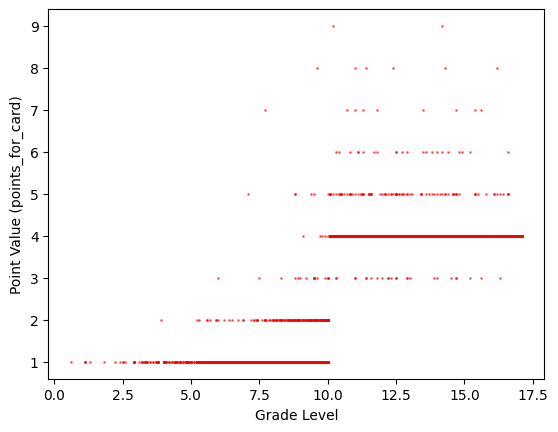

In [ ]:
# remove cards that are beyond the 95th percentile using IQR method
# calculate the 95th percentile
grade_level_95th_percentile = df['grade_level'].quantile(0.95)
# remove cards that are beyond the 95th percentile
df = df[df['grade_level'] < grade_level_95th_percentile]
# remove any cards with negative point values or grade levels
df = df[df['point_value'] > 0]
df = df[df['grade_level'] > 0]
# show the distribution of grade levels

# plot grade levels vs point values
import matplotlib.pyplot as plt
plt.scatter(df['grade_level'], df['points_for_card'], color='red', alpha=0.5, s=1)
plt.xlabel('Grade Level')
plt.ylabel('Point Value (points_for_card)')
plt.show()

In [ ]:
# show me examples of cards with grade_level below 2
df[df['grade_level'] < 2].head()
# df[df['grade_level'] > 12].head()

,title,summary,related,summary_short,summary_clean,point_value,grade_level,points_for_card,acronym,years_in_summary,years_in_title,points_by_year_mentioned
830,Stop That Roach!,"Stop That Roach!, Stop That Roach!, known in J...",26,", known in Japan as Hoi Hoi: Game Boy Ban , is...",NaN,26,0.6,1,False,0,0,2
2860,Mr. Do's Wild Ride,"Mr. Dos Wild Ride, Mr. Dos Wild Ride is a plat...",20,"- Dos - Ride, - Dos - - is a platfor...",NaN,20,1.8,1,False,2,0,2
5911,Rangile Dost,"Rangile Dost, Rangile Dost is a Bollywood film...",6,is a Bollywood film. It was released in 1944.\n\n,NaN,6,1.1,1,False,1,0,2
6739,Those who live in glass houses should not thro...,Those who live in glass houses should not thro...,1,,NaN,1,1.3,1,False,0,0,2
7786,Chehra (1946 film),"Chehra 1946 film, Chehra is a Bollywood film. ...",7,"- 1946 film, - is a Bollywood film. It was...",NaN,7,1.1,1,False,2,1,2


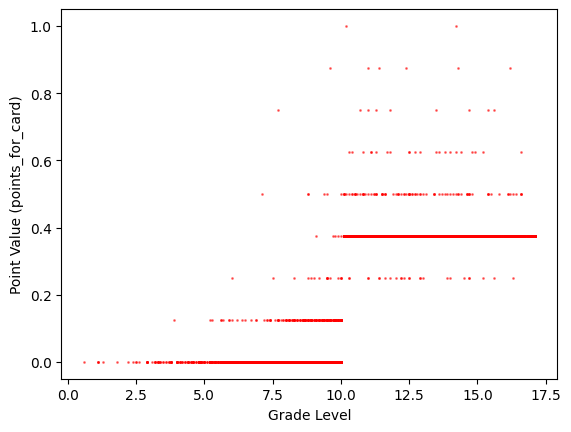

In [ ]:
# use min-max normalization to normalize the point values
# calculate the min and max point values
min_point_value = df['points_for_card'].min()
max_point_value = df['points_for_card'].max()
# normalize the point values
df['points_for_card'] = (df['points_for_card'] - min_point_value) / (max_point_value - min_point_value)
# plot grade levels vs point values
import matplotlib.pyplot as plt
plt.scatter(df['grade_level'], df['points_for_card'], color='red', alpha=0.5, s=1)
plt.xlabel('Grade Level')
plt.ylabel('Point Value (points_for_card)')
plt.show()


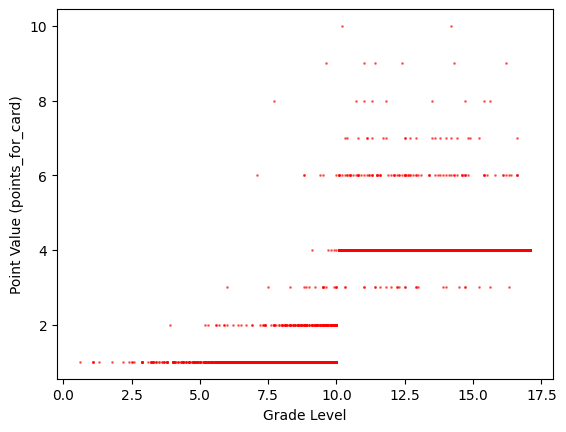

In [ ]:
# now use minmaxscaler to normalize the point values between 0, and 10 by steps of 1 (i.e. 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10) using rounding to the nearest integer. This will be used to generate the point values for the cards.
from sklearn.preprocessing import MinMaxScaler
import numpy as np
# create a MinMaxScaler object
scaler = MinMaxScaler(feature_range=(1, 10))
# fit the scaler to the point values
scaler.fit(df[['points_for_card']])
# transform the point values
df['points_for_card'] = scaler.transform(df[['points_for_card']])
# round the point values to the nearest integer
df['points_for_card'] = df['points_for_card'].round()
# plot grade levels vs point values
import matplotlib.pyplot as plt
plt.scatter(df['grade_level'], df['points_for_card'], color='red', alpha=0.5, s=1)
plt.xlabel('Grade Level')
plt.ylabel('Point Value (points_for_card)')
plt.show()

In [ ]:
# show an example by random sample of 1
df.sample(1)

,title,summary,related,summary_short,summary_clean,point_value,grade_level,points_for_card,acronym,years_in_summary,years_in_title,points_by_year_mentioned
2736,Kathryn Janeway,"Kathryn Janeway, Kathryn Janeway is a fictiona...",109,is a fictional character in the Star Trek fran...,NaN,109,9.7,1.0,False,1,0,2


In [ ]:
# save the dataframe to a json file in place of the ppn_deck.json file
df.to_json('ppn_deck.json', orient='records')
